## AA-test

In [1]:
import pandas as pd
import pandahouse as ph
from scipy import stats
import hashlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##### Хэширование с солью

Посмотреть для себя, как работает система сплитования.



In [2]:
connection = {'host' : 'https://clickhouse.lab.karpov.courses',
              'database' : 'simulator_20220820',
              'user' : 'student',
              'password' : 'dpo_python_2020'
             }

query = '''
    SELECT user_id,
           countIf(user_id, action = 'like' ) as like,
           countIf(user_id, action = 'view' ) as view,
           like/view as CTR,
           exp_group
      FROM {db}.feed_actions
      WHERE toDate(time) >= '2022-07-06' and toDate(time) <= '2022-07-12'
      GROUP BY user_id, exp_group
      '''

df = ph.read_clickhouse(query, connection = connection)

In [3]:
def ab_split(id, salt='exp_mess_1', n_groups=5):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [4]:
df['hash_group'] = df.user_id.apply(ab_split)
df.groupby('hash_group').user_id.nunique().reset_index()

,hash_group,user_id
0,0,8725
1,1,8354
2,2,8516
3,3,8433
4,4,8557


In [5]:
q = """
    SELECT xxHash64(toString(user_id)||'my_salt')%5 as group,
           uniqExact(user_id)
      FROM {db}.feed_actions
     WHERE toDate(time) >= '2022-07-06' and toDate(time) <= '2022-07-12'
     GROUP BY group
"""
ph.read_clickhouse(q, connection=connection)

,group,uniqExact(user_id)
0,0,8552
1,1,8496
2,2,8491
3,3,8559
4,4,8487


## Задание 1.

Итак, что нужно сделать: у нас есть данные АА-теста с **'2022-07-06' по '2022-07-12'**. Вам нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

4. Пришлите ссылку на merge request c проведенным анализом.

**Построить гистограмму распределения получившихся 10000 p-values**

Посмотрим, что представляют из себя наши экспериментальные группы.

In [6]:
df_g = df.query('exp_group == 2 | exp_group == 3')

In [4]:
df_g

,user_id,like,view,CTR,exp_group
0,115383,11,36,0.305556,3
2,123580,15,92,0.163043,3
3,131473,26,148,0.175676,2
5,24239,53,119,0.445378,2
6,118359,13,112,0.116071,3
...,...,...,...,...,...
42579,1560,7,37,0.189189,2
42580,122758,37,212,0.174528,3
42582,122190,25,74,0.337838,3
42583,108927,8,33,0.242424,2


In [6]:
df_g.groupby('exp_group')['CTR'].agg(['mean', 'median', 'count'])

,mean,median,count
exp_group,,,
2,0.218246,0.205882,8480
3,0.219161,0.206612,8569


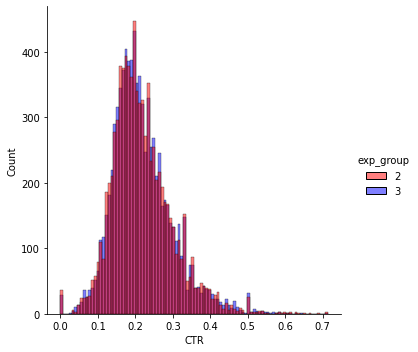

In [4]:
sns.displot(x='CTR',
            hue='exp_group',
            data=df_g,
            palette = ['r', 'b']);

In [7]:
stats.ttest_ind(df_g.query('exp_group == 2')['CTR'], df_g.query('exp_group == 3')['CTR'], equal_var = False)

Ttest_indResult(statistic=-0.739359792495814, pvalue=0.45969873156477636)

Распредление визуально выглядит одинаковыми для обеих групп. T-test по средним CTR показал, что отклонить Н0 о равенстве средних нельзя (p-value = 0.4596 > 0.05 = α).

Проведем симуляцию из 10 000 АА-тестов и сравним средние CTR. Нулевой гипотезой будет предположение об их равенстве.

In [8]:
pval_list = []
n_exp = 10000
n_samples = 500

for i in range(n_exp):
    sec_gr = df_g.query('exp_group == 2')['CTR'].sample(n_samples, replace = False)
    th_gr = df_g.query('exp_group == 3')['CTR'].sample(n_samples, replace = False)
    pval = stats.ttest_ind(sec_gr, th_gr, equal_var = False)
    pval_list.append(pval[1])

In [9]:
pval_sr = pd.Series(pval_list)

<AxesSubplot:ylabel='Count'>

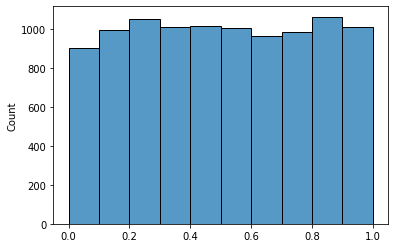

In [10]:
sns.histplot(pval_sr, bins = 10)

**Посчитать, какой процент p values оказался меньше либо равен 0.05**

In [11]:
percent = len(pval_sr[pval_sr <= 0.05])/len(pval_sr)*100
print(f'{percent:.2f}% p-values оказался меньше либо равен 0.05')

4.54% p-values оказался меньше либо равен 0.05


**Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.**

- Распредление p-values носит равномерный характер
- Лишь в примерно 5% случаях показатели p-values позволяют отвернуть Н0

Т.о., можно утверждать, что система сплитования работает корректно.